In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import sklearn 
import time
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, f1_score

data = pd.read_csv('creditcard_2023.csv')

print(data.shape)

data = data.sample(frac=0.02, random_state=42)

(568630, 31)


In [3]:
print('Shape of the dataset: ', data.shape)
data.sample(3)

Shape of the dataset:  (11373, 31)


,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
383918,383918,-0.936441,0.328861,-0.832026,0.831845,-0.815711,-0.206050,-0.825033,0.077651,-0.846532,...,0.044106,0.475270,0.602575,-0.226606,-0.329226,-0.564455,0.929490,0.989498,306.76,1
524910,524910,1.328119,-0.055775,-0.091257,0.585075,0.822926,0.110517,0.644959,-0.164231,-0.194544,...,-0.167108,-0.421284,-0.041601,-0.645106,0.425110,0.049958,-0.249528,-0.032165,12396.06,1
4001,4001,1.083819,-0.313032,0.640521,-0.359544,0.291795,0.218771,0.446088,-0.218850,1.357516,...,-0.286226,-0.904291,0.001249,-0.831018,0.482056,0.247123,-0.295208,-0.081260,1462.31,0


In [4]:
## Data Preprocessing 

print("Missing Values for corrosponding Features: ")
data.isna().sum() ## Checking for Missing Values

Missing Values for corrosponding Features: 


id        0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [5]:
print("Are there any duplicate values in this dataset?")
data.duplicated().any() ## Check if the dataset contains any duplicate values

Are there any duplicate values in this dataset?


False

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11373 entries, 437378 to 375058
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      11373 non-null  int64  
 1   V1      11373 non-null  float64
 2   V2      11373 non-null  float64
 3   V3      11373 non-null  float64
 4   V4      11373 non-null  float64
 5   V5      11373 non-null  float64
 6   V6      11373 non-null  float64
 7   V7      11373 non-null  float64
 8   V8      11373 non-null  float64
 9   V9      11373 non-null  float64
 10  V10     11373 non-null  float64
 11  V11     11373 non-null  float64
 12  V12     11373 non-null  float64
 13  V13     11373 non-null  float64
 14  V14     11373 non-null  float64
 15  V15     11373 non-null  float64
 16  V16     11373 non-null  float64
 17  V17     11373 non-null  float64
 18  V18     11373 non-null  float64
 19  V19     11373 non-null  float64
 20  V20     11373 non-null  float64
 21  V21     11373 non-null  float64
 2

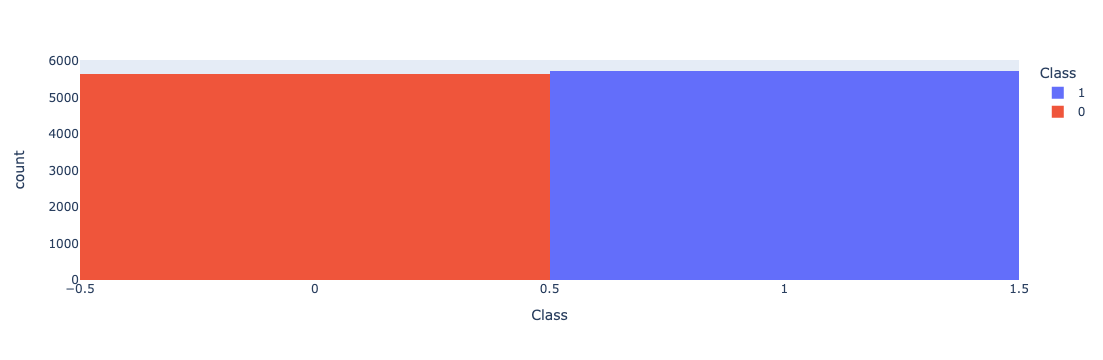

In [7]:
## Data Exploration

#Checking Credit card fraud Class
px.histogram(data_frame = data, x='Class', color='Class')

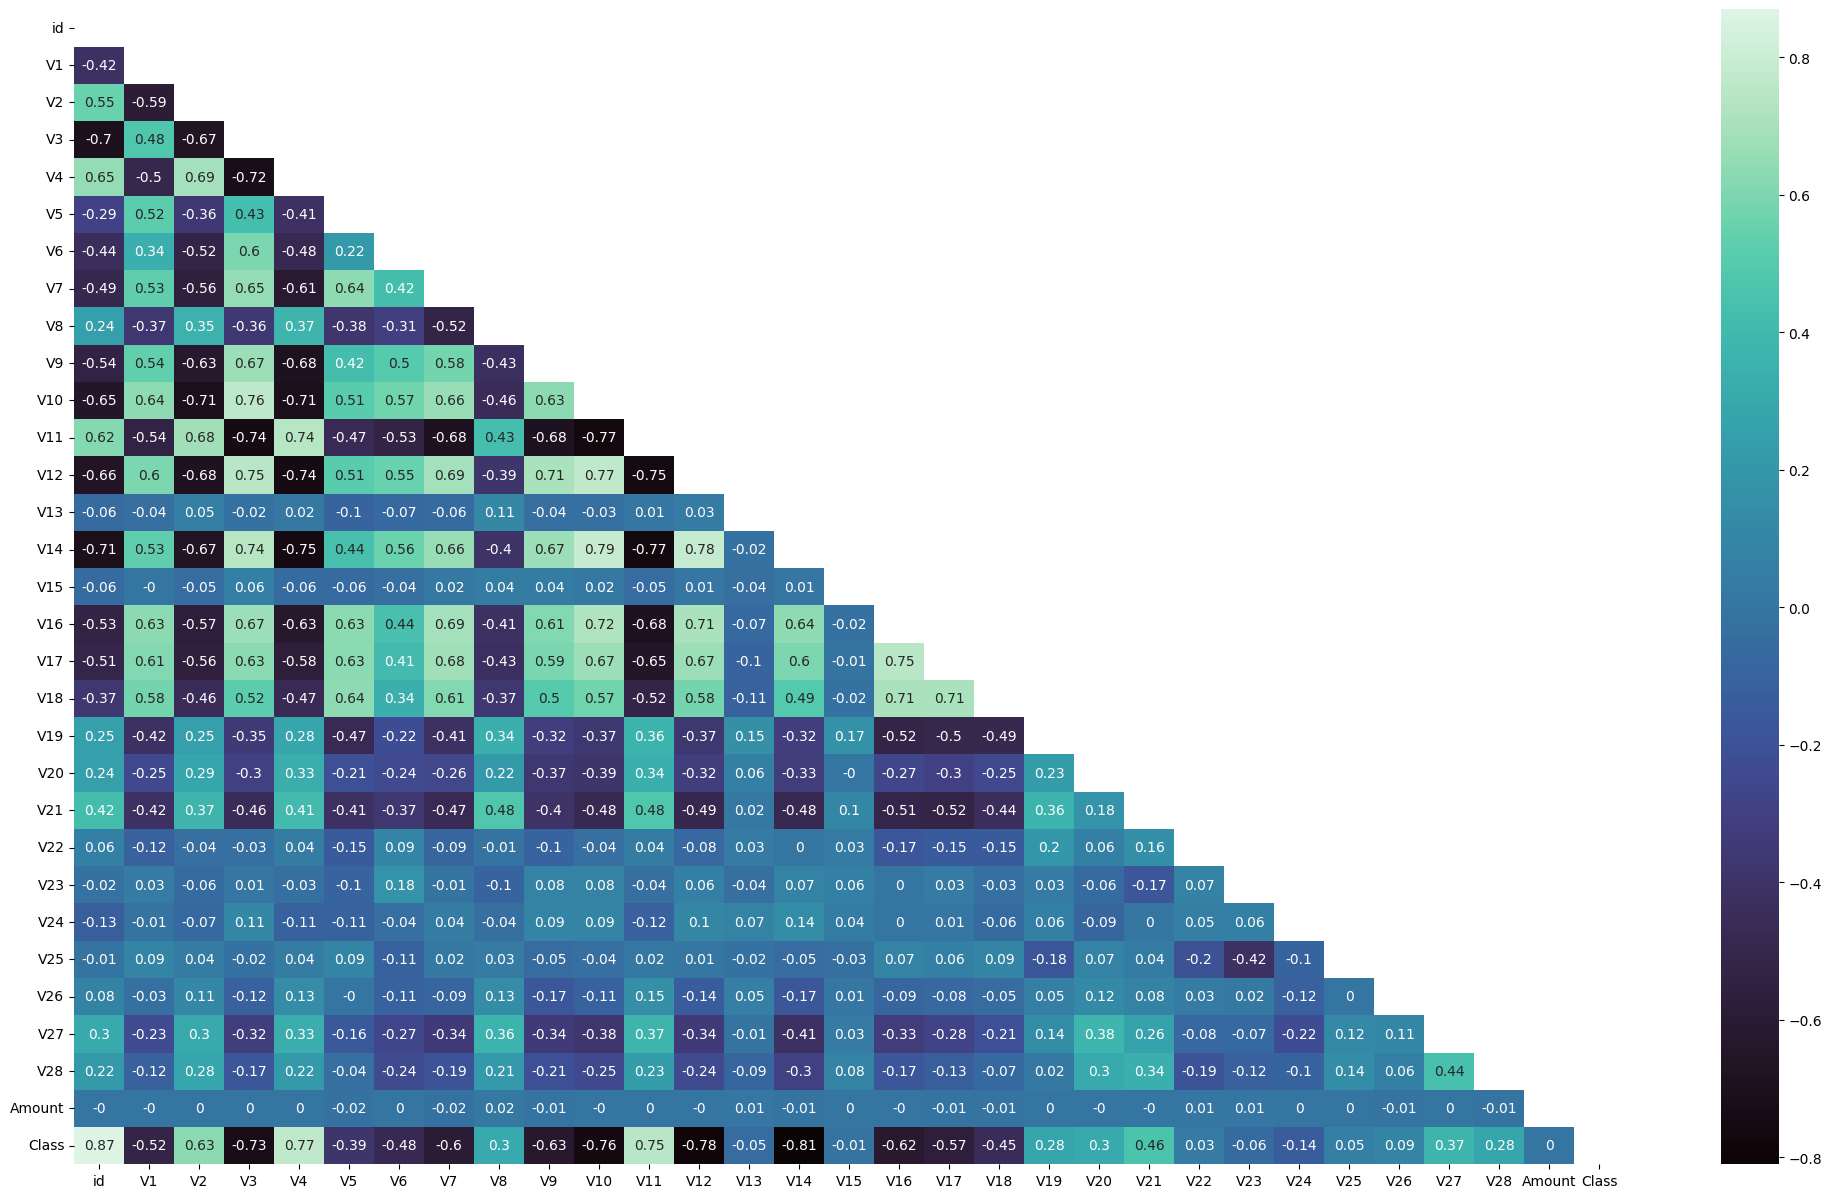

In [8]:
corr_df = data.corr(method = 'spearman').round(2)
mask = np.triu(np.ones_like(corr_df, dtype=bool))
plt.figure(figsize=[25,15])
sns.heatmap(corr_df, cmap=sns.color_palette("mako", as_cmap = True), annot=True, mask = mask)
plt.show()


In [9]:
def generate_corr_mat(df, high = 0.6, low = 0.1):
    """
        Filter the parameters based on their correlations' magnitude
    """
    corr_mat = {'highly_corr': dict(), 'low_corr': dict()}
    df = df.abs()
    cols = df.columns.tolist()
    for i, val in df.iterrows():
        corr_mat['highly_corr'][i] = [col for col in cols if val[col] > high and col != i]
        corr_mat['low_corr'][i] = [col for col in cols if val[col] < low]
        print(f"Highly correlared  with parameter \033[1m{i}\033[0m is/are: ", corr_mat['highly_corr'][i])
        print(f"Parameters having apprx no co-relation with parameter \033[1m{i}\033[0m is/are: ", corr_mat['low_corr'][i])
        print()
    return corr_mat

correlation_matrix = generate_corr_mat(corr_df)

Highly correlared  with parameter id is/are:  ['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'Class']
Parameters having apprx no co-relation with parameter id is/are:  ['V13', 'V15', 'V22', 'V23', 'V25', 'V26', 'Amount']

Highly correlared  with parameter V1 is/are:  ['V10', 'V16', 'V17']
Parameters having apprx no co-relation with parameter V1 is/are:  ['V13', 'V15', 'V23', 'V24', 'V25', 'V26', 'Amount']

Highly correlared  with parameter V2 is/are:  ['V3', 'V4', 'V9', 'V10', 'V11', 'V12', 'V14', 'Class']
Parameters having apprx no co-relation with parameter V2 is/are:  ['V13', 'V15', 'V22', 'V23', 'V24', 'V25', 'Amount']

Highly correlared  with parameter V3 is/are:  ['id', 'V2', 'V4', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'Class']
Parameters having apprx no co-relation with parameter V3 is/are:  ['V13', 'V15', 'V22', 'V23', 'V25', 'Amount']

Highly correlared  with parameter V4 is/are:  ['id', 'V2', 'V3', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'Class']
Parameters h

In [10]:
##Checking skewness of the data using pandas

# If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
# If the skewness is between -1 and -0.5 or between 0.5 and 1, the data are moderately skewed
# If the skewness is less than -1 or greater than 1, the data are highly skewed

data.skew().sort_values()

V28      -1.332642
V23      -0.382439
V21      -0.327479
V7       -0.204065
V5       -0.116651
V6       -0.108922
V27      -0.078909
V1       -0.070115
V26      -0.028683
V4       -0.017250
V15      -0.013032
Class    -0.012136
V11      -0.008856
V3       -0.006359
id       -0.005441
Amount    0.008352
V19       0.011373
V16       0.019581
V13       0.020723
V12       0.042966
V25       0.052496
V24       0.105423
V20       0.110902
V18       0.123987
V9        0.127521
V14       0.268361
V17       0.348057
V22       0.388430
V8        0.579809
V10       0.591719
V2        0.771572
dtype: float64

In [11]:
# Observations

# Features like V20, V2 are highly -vely skewed.
# Features like V5, V28, V27 and V7 are highly +vely skewed.

<Axes: xlabel='Amount', ylabel='Density'>

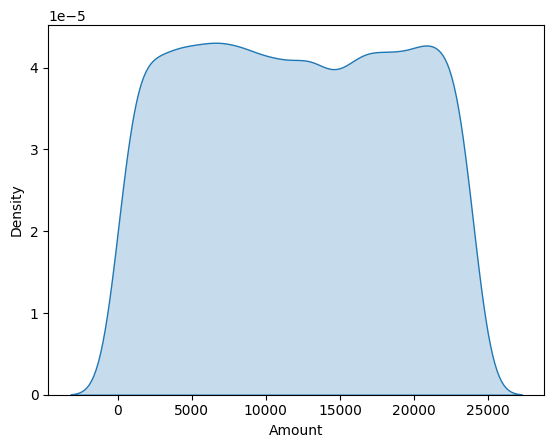

In [12]:
#visualize the distribution of the 'Amount' variable in the dataset using a KDE plot. 
sns.kdeplot(data = data['Amount'], fill=True)

In [13]:
## OBservation: Data is fairly normally / Gaussian distributed.

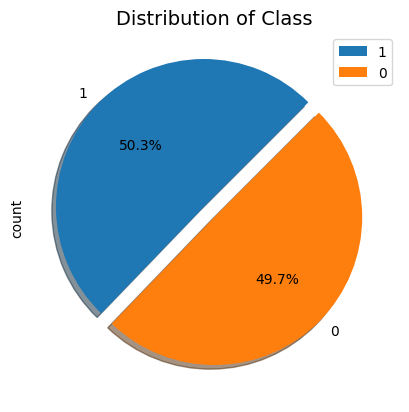

In [14]:
## Pie plot to identify data divided into Fraudulent / Actual Transactions

data['Class'].value_counts().plot.pie(explode=[0.1,0],autopct='%3.1f%%'
                                     ,shadow=True, legend= True,startangle =45)
plt.title('Distribution of Class',size=14)
plt.show()

In [15]:
## Observation: Dataset is balanced.

In [16]:
def model_evaluvation(model, X_train, y_train, X_test, y_test):

    model.fit(X_train, y_train)
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred)
    
    print('Accuracy: ', accuracy)
    print('F1 Score: ', f1)
    print('AUC(ROC): ', roc_auc)
    print()
    print("Classification Report: ")
    print(classification_report(y_test, y_pred))
    
    ## ROC AUC
    
    prob = model.predict_proba(X_test)  
    prob = prob[:, 1]
    fper, tper, _ = roc_curve(y_test, prob)
    auc_scr = auc(fper, tper)
    
    
    fig, axes = plt.subplots(1, 2, figsize = (12, 6))
    axes[0].plot(fper, tper, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_scr)
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')
    axes[0].legend(loc="lower right")
    
    sns.heatmap(confusion_matrix(y_test, y_pred), ax = axes[1], annot = True, cbar = False)
    axes[1].set_xlabel('Predicted labels')
    axes[1].set_ylabel('Actual labels')
    
    plt.show()
    
    # Return evaluation metrics
    return model, accuracy, f1, roc_auc

In [17]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(data, data.Class, test_size=0.3,random_state=109) # 70% training and 30% test

In [18]:
## USING MODELS TO EVALUVATE:

## 1) SUPPORT VECTOR MACHINES

#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [19]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(data, data.Class, test_size=0.3,random_state=109) # 70% training and 30% test


In [20]:
## Checking SVM Model Overall Performance

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.9988276670574443


In [21]:
## Observation: A precision of 1.0 suggests that the model makes no false positive predictions, 
## while a recall of 0.9976 suggests that it captures almost all positive instances in the dataset.

In [22]:
## Dividing data into dependent and Independent classes

x = data.drop(columns = ['Class'], axis=1)
y = data.Class

In [23]:
## Applying Feature scaling as a part of pre-processing technique to improve the data

## Feature Scaling 

sc = StandardScaler()

x_scaled = sc.fit_transform(x) 
x_scaled_df = pd.DataFrame(x_scaled,columns=x.columns)
x_scaled_df.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.933082,0.413316,-0.077087,-0.575653,0.191364,-0.006670,0.447695,-0.390365,0.092135,0.074514,...,0.253805,0.144115,0.063261,0.051471,-0.854357,0.096052,-0.375729,0.836765,0.678074,-0.489665
1,1.342160,-0.250610,0.268359,-0.378599,0.152214,-0.107886,-0.030292,-0.321482,0.131175,-0.604635,...,0.359122,0.205149,0.292549,-0.288057,-0.820289,0.305137,1.596329,0.583262,0.485684,0.039659
2,-1.714289,-0.128633,-0.160744,2.154509,-0.331607,0.348982,0.288118,0.830436,-0.261117,1.253580,...,0.118754,-0.288073,-0.434125,-0.137936,0.850332,0.542956,0.764296,-0.252824,-0.418859,-0.983031
3,0.633408,-0.871201,0.145817,-0.635168,0.617940,-0.679271,-0.671725,-0.956053,0.476469,-1.065096,...,0.598104,0.431600,0.164948,0.498067,-0.210446,0.492735,0.665684,1.647869,-0.031558,1.047876
4,0.854343,0.249420,0.036341,-0.205371,0.509807,-0.253475,-0.187846,-0.317474,0.038543,-0.406289,...,0.133553,0.173043,0.163222,-0.206035,0.325537,1.053104,0.032389,0.654100,0.750660,1.023518


In [24]:
## Principal Component Analysis

pca = PCA(n_components = 12)
x_new = pd.DataFrame(pca.fit_transform(x_scaled), columns = ['Col_'+ str(i) for i in range(12)])
# pickle.dumps(open('pca.pkl', 'wb'), pca)
x_new.head(3)

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,Col_10,Col_11
0,1.800552,-0.645452,0.889269,0.476609,0.681644,-0.618510,-0.714032,0.459504,0.897018,-0.597337,0.601327,0.189256
1,2.492247,-0.700321,0.053365,0.155111,1.510937,0.796611,-0.819691,-0.006763,-0.239058,-0.086344,0.025441,-0.524913
2,-2.215672,0.205352,-2.068288,-0.066477,-0.528555,2.182204,0.320675,1.062828,-1.333455,-0.683997,-0.831225,0.002814


In [25]:
## Splitting the Data

x_train,x_test,y_train,y_test = train_test_split(x_new, y, test_size=0.25, random_state=15, stratify= y)

## Why are we using stratified K folds here ?

# Stratified folding helps to mitigate the risk of introducing bias into
# the evaluation process, especially when dealing with imbalanced datasets. 
# It ensures that each class is represented adequately in both the training and validation sets, 
# leading to more reliable estimates of the model's performance.

cv = StratifiedKFold(n_splits = 8, shuffle = True)

Accuracy:  0.9834739803094233
F1 Score:  0.9834741376375256
AUC(ROC):  0.9834888969007465

Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1413
           1       0.99      0.98      0.98      1431

    accuracy                           0.98      2844
   macro avg       0.98      0.98      0.98      2844
weighted avg       0.98      0.98      0.98      2844

Model is an instance of SVC. Using decision_function for ROC curve.


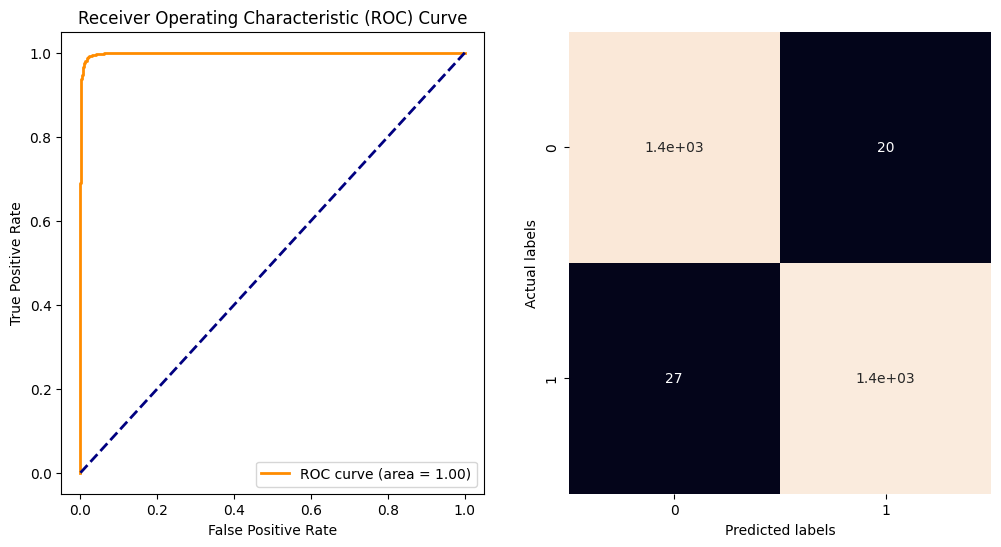

In [26]:
def evaluate_svm(model, X_train, y_train, X_test, y_test):
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred)
    
    print('Accuracy: ', accuracy)
    print('F1 Score: ', f1)
    print('AUC(ROC): ', roc_auc)
    print()
    print("Classification Report: ")
    print(classification_report(y_test, y_pred))
    
    # Compute ROC curve
    print("Model is an instance of SVC. Using decision_function for ROC curve.")
    decision_scores = model.decision_function(X_test)
    prob = (decision_scores - decision_scores.min()) / (decision_scores.max() - decision_scores.min())
    
    fper, tper, _ = roc_curve(y_test, prob)
    auc_scr = auc(fper, tper)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].plot(fper, tper, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_scr)
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')
    axes[0].legend(loc="lower right")
    
    sns.heatmap(confusion_matrix(y_test, y_pred), ax=axes[-1], annot=True, cbar=False)
    axes[-1].set_xlabel('Predicted labels')
    axes[-1].set_ylabel('Actual labels')
    
    plt.show()
    
    # Return evaluation metrics
    return model, accuracy, f1, roc_auc


model_SVM = SVC()
time_start = time.time()
model_svm, acc_svm, f1_svm, roc_auc_svm = evaluate_svm(model_SVM, x_train, y_train, x_test, y_test)
time_taken_svm = time.time() - time_start

Accuracy:  0.9774964838255977
F1 Score:  0.9774966841462046
AUC(ROC):  0.9775222885425985

Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1413
           1       0.98      0.97      0.98      1431

    accuracy                           0.98      2844
   macro avg       0.98      0.98      0.98      2844
weighted avg       0.98      0.98      0.98      2844



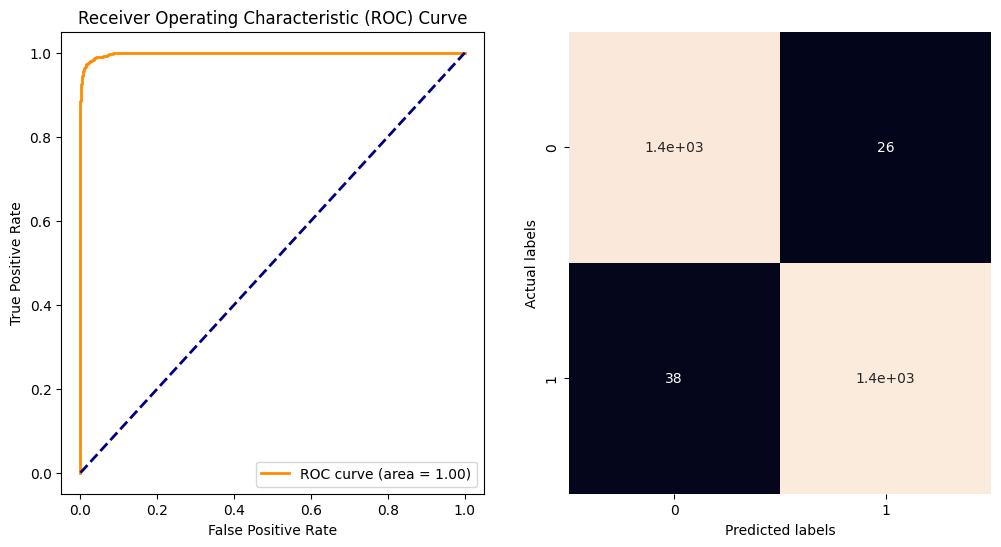

In [27]:
model_lr = LogisticRegression()
time_start = time.time()
model_lr, acc_lr, f1_lr, roc_auc_lr = model_evaluvation(model_lr, x_train, y_train, x_test, y_test)
time_taken_lr = time.time() - time_start

Accuracy:  0.9462025316455697
F1 Score:  0.9461758169235951
AUC(ROC):  0.9463628392242742

Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1413
           1       0.97      0.92      0.95      1431

    accuracy                           0.95      2844
   macro avg       0.95      0.95      0.95      2844
weighted avg       0.95      0.95      0.95      2844



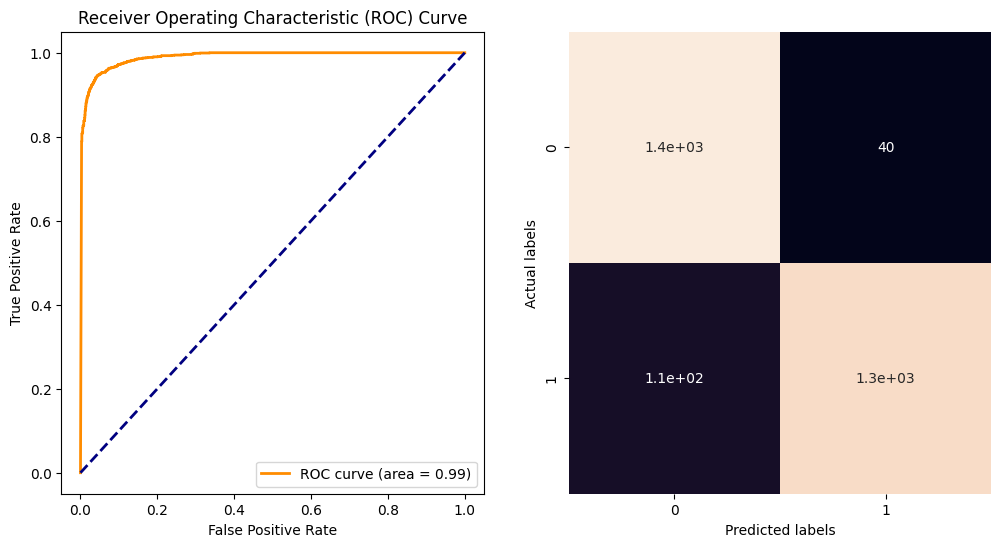

In [28]:
model_gnb = GaussianNB()
time_start = time.time()
model_gnb, acc_gnb, f1_gnb, roc_auc_gnb = model_evaluvation(model_gnb, x_train, y_train, x_test, y_test)
time_taken_gnb = time.time() - time_start

Accuracy:  0.9736286919831224
F1 Score:  0.9736283170112143
AUC(ROC):  0.973616507987377

Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1413
           1       0.97      0.98      0.97      1431

    accuracy                           0.97      2844
   macro avg       0.97      0.97      0.97      2844
weighted avg       0.97      0.97      0.97      2844



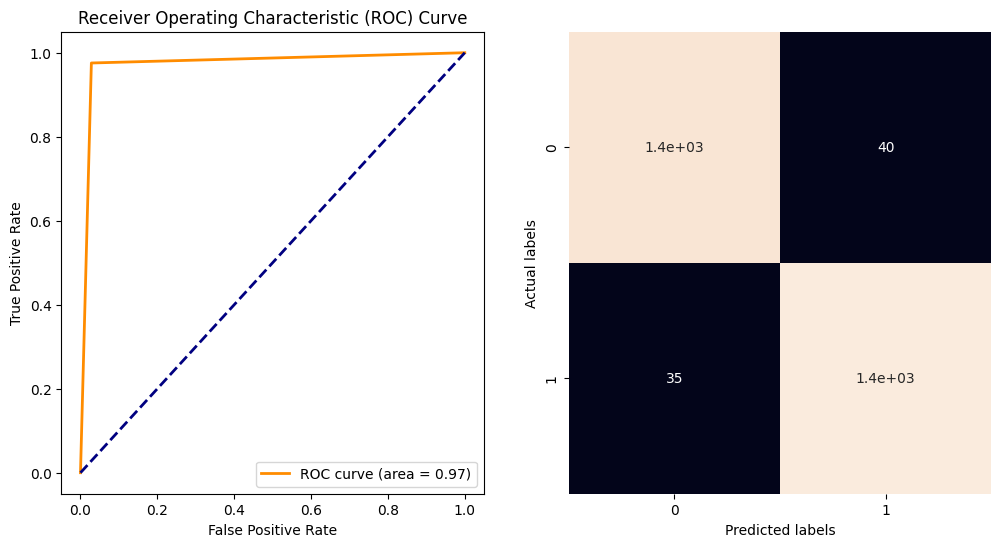

In [29]:
model_dt = DecisionTreeClassifier()
time_start = time.time()
model_dt, acc_dt, f1_dt, roc_auc_dt = model_evaluvation(model_dt, x_train, y_train, x_test, y_test)
time_taken_dt = time.time() - time_start

Accuracy:  0.9852320675105485
F1 Score:  0.9852321989709469
AUC(ROC):  0.9852581821095221

Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1413
           1       0.99      0.98      0.99      1431

    accuracy                           0.99      2844
   macro avg       0.99      0.99      0.99      2844
weighted avg       0.99      0.99      0.99      2844



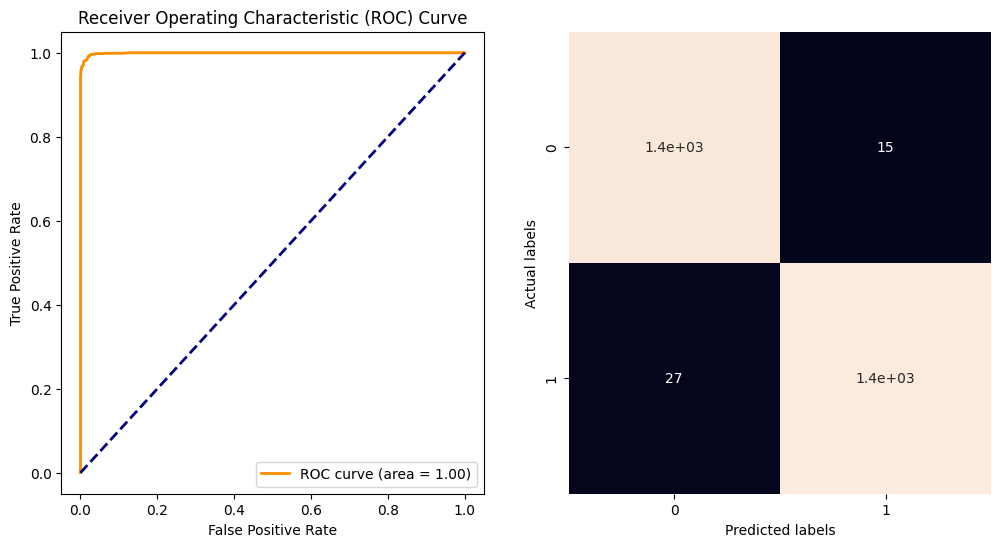

In [30]:
model_rf = RandomForestClassifier()
time_start = time.time()
model_rf, acc_rf, f1_rf, roc_auc_rf = model_evaluvation(model_rf, x_train, y_train, x_test, y_test)
time_taken_rf = time.time() - time_start

In [31]:
accuracies = [acc_svm, acc_lr, acc_gnb, acc_dt, acc_rf]
f_score = [f1_svm, f1_lr, f1_gnb, f1_dt, f1_rf]
roc_auc = [roc_auc_svm, roc_auc_lr, roc_auc_gnb, roc_auc_dt, roc_auc_rf]
time = [time_taken_svm, time_taken_lr, time_taken_gnb, time_taken_dt, time_taken_rf]

final_df = pd.DataFrame({"Accuracies": accuracies, "F1 Scores": f_score, "ROC AUC": roc_auc, "Time Taken": time}, 
                       index = ['SVM', 'LogisticReg', 'GaussianNB', 'DecisionTree', 'RandomForest'])
final_df = final_df.round(4)
final_df

,Accuracies,F1 Scores,ROC AUC,Time Taken
SVM,0.9835,0.9835,0.9835,0.4545
LogisticReg,0.9775,0.9775,0.9775,0.4687
GaussianNB,0.9462,0.9462,0.9464,0.1770
DecisionTree,0.9736,0.9736,0.9736,0.2884
RandomForest,0.9852,0.9852,0.9853,1.9155
